In [1]:
import numpy as np
from sray.utils.draw_utils import draw_aabb, draw_cam
import plotly.express as px
from sray.dataset.database import ScannetDatabase
import os
import torch

In [2]:
class Camera:
    def __init__(self, cam_id,W2C, K, near_clip=None, far_clip=None):
        # 相机到世界坐标的变换
        self.cam_id = cam_id
        W2C = np.array(W2C)
        self.World2Camera = np.eye(4)
        self.World2Camera[:3,:4]  =W2C
        # 近裁剪面和远裁剪面
        self.near_clip = near_clip
        self.far_clip = far_clip
        # 从内参矩阵中提取相机参数
        self.fx = K[0, 0]
        self.fy = K[1, 1]
        self.cx = K[0, 2]
        self.cy = K[1, 2]
    def check_points_inside_frustum(self, points):
        # 将点从世界坐标转换到相机坐标
        homogeneous_points = np.column_stack((points, np.ones(points.shape[0])))
        camera_coords = self.World2Camera.dot(homogeneous_points.T).T[:, :3]
        # 计算点与相机的距离
        distances = np.linalg.norm(camera_coords, axis=1)
        # 远近裁剪面判断
        if self.near_clip is not None and self.far_clip is not None:
            inside_near_far = (distances > self.near_clip) & (distances < self.far_clip)
        else:
            inside_near_far = (distances > 0.1) & (distances < 8)
            # inside_near_far = np.ones_like(camera_coords[:, 0]).astype(bool)
        # 计算点在相机坐标中的x,y坐标
        projected_x = camera_coords[:, 0] * self.fx / camera_coords[:, 2] + self.cx
        projected_y = camera_coords[:, 1] * self.fy / camera_coords[:, 2] + self.cy
         
        # 判断是否在视锥内
        inside_frustum_x = np.abs(projected_x - self.cx) < self.cx
        inside_frustum_y = np.abs(projected_y - self.cy) < self.cy
        fron_cam = camera_coords[:,2] >= 1e-2
        inside_frustum = inside_frustum_x & inside_frustum_y & inside_near_far & fron_cam
        return inside_frustum

In [3]:
def top_k_indices(arr, k):
    # 使用 argsort 对数组进行排序并获取索引
    sorted_indices = np.argsort(arr)
    
    # 返回 top k 的索引
    return sorted_indices[-k:][::-1]

In [4]:
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2, multiprocessing_context=mp.get_context())

In [5]:
def generate_sample_points(aabb, resolution):
    xmin, ymin, zmin, xmax, ymax, zmax = aabb
    x_res, y_res, z_res = resolution

    # 使用linspace生成在每个轴上的均匀间隔的点
    x = np.linspace(xmin, xmax, x_res)
    y = np.linspace(ymin, ymax, y_res)
    z = np.linspace(zmin, zmax, z_res)

    # 使用meshgrid在三维空间中创建一个坐标网格
    X, Y, Z = np.meshgrid(x, y, z)

    # 将坐标网格重塑为点的列表
    sample_points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

    return sample_points

In [47]:
@torch.compile
def select_cameras(aabb,target_c2w,target_w2c,target_k,cam_ids,c2ws, w2cs,Ks, N1,N2):
    class Camera:
        def __init__(self, cam_id,W2C, K, near_clip=None, far_clip=None):
            # 相机到世界坐标的变换
            self.cam_id = cam_id
            W2C = np.array(W2C)
            self.World2Camera = np.eye(4)
            self.World2Camera[:3,:4]  =W2C
            # 近裁剪面和远裁剪面
            self.near_clip = near_clip
            self.far_clip = far_clip
            # 从内参矩阵中提取相机参数
            self.fx = K[0, 0]
            self.fy = K[1, 1]
            self.cx = K[0, 2]
            self.cy = K[1, 2]
        def check_points_inside_frustum(self, points):
            # 将点从世界坐标转换到相机坐标
            homogeneous_points = np.column_stack((points, np.ones(points.shape[0])))
            camera_coords = self.World2Camera.dot(homogeneous_points.T).T[:, :3]
            # 计算点与相机的距离
            distances = np.linalg.norm(camera_coords, axis=1)
            # 远近裁剪面判断
            if self.near_clip is not None and self.far_clip is not None:
                inside_near_far = (distances > self.near_clip) & (distances < self.far_clip)
            else:
                inside_near_far = (distances > 0.1) & (distances < 8)
                # inside_near_far = np.ones_like(camera_coords[:, 0]).astype(bool)
            # 计算点在相机坐标中的x,y坐标
            projected_x = camera_coords[:, 0] * self.fx / camera_coords[:, 2] + self.cx
            projected_y = camera_coords[:, 1] * self.fy / camera_coords[:, 2] + self.cy
             
            # 判断是否在视锥内
            inside_frustum_x = np.abs(projected_x - self.cx) < self.cx
            inside_frustum_y = np.abs(projected_y - self.cy) < self.cy
            fron_cam = camera_coords[:,2] >= 1e-2
            inside_frustum = inside_frustum_x & inside_frustum_y & inside_near_far & fron_cam
            return inside_frustum
    target_cam = Camera('',target_w2c,target_k)

    remaining_cameras = np.asarray([Camera(idx,w2c,K) for idx,w2c,K in zip(cam_ids,w2cs,Ks)])
    resolution = (50, 50, 20)
    aabb_points = generate_sample_points(aabb, resolution)
    valid_points_inds = target_cam.check_points_inside_frustum(aabb_points)
    valid_points_num = np.sum(valid_points_inds)
    valid_points = aabb_points[valid_points_inds]

    target_cam_pts = np.array(target_c2w[:3,3])
    remaining_cam_pts = np.array([c2w[:3,3] for c2w in c2ws])
    dists = np.linalg.norm(target_cam_pts[None,None] - remaining_cam_pts[None], 2, 2)
    dists_idx = np.argsort(dists,1)[0]
    nearest_id = dists_idx[:N1]

    selected_cameras = remaining_cameras[nearest_id].tolist()
    remaining_cameras = np.delete(remaining_cameras,nearest_id, axis=0)

    rets2 = []

    remaining_cameras = np.random.permutation(remaining_cameras)
    for camera in remaining_cameras[:100]:
        intersection1 = camera.check_points_inside_frustum(aabb_points)
        intersection2 = np.logical_and(valid_points_inds,intersection1)
        # intersection3 = np.logical_and(select_ind,intersection1)
        if np.sum(intersection2) > 0.3*valid_points_num :
            intersection = np.logical_and(intersection1,~intersection2)
            rets2.append(np.sum(intersection))
            valid_points_inds = np.logical_or(valid_points_inds,intersection1)
            valid_points_num = np.sum(valid_points_inds)
        else:
            rets2.append(-1*np.inf)
    nearest_id2 = top_k_indices(rets2,N2)
    cameras = selected_cameras + remaining_cameras[nearest_id2].tolist()
    
    return cameras,aabb_points[valid_points_inds]

In [48]:
def select_cameras_origin(aabb,target_c2w,target_w2c,target_k,cam_ids,c2ws, w2cs,Ks, N1,N2):
    target_cam = Camera('',target_w2c,target_k)

    remaining_cameras = np.asarray([Camera(idx,w2c,K) for idx,w2c,K in zip(cam_ids,w2cs,Ks)])
    resolution = (50, 50, 20)
    aabb_points = generate_sample_points(aabb, resolution)
    valid_points_inds = target_cam.check_points_inside_frustum(aabb_points)
    valid_points_num = np.sum(valid_points_inds)
    valid_points = aabb_points[valid_points_inds]

    target_cam_pts = np.array(target_c2w[:3,3])
    remaining_cam_pts = np.array([c2w[:3,3] for c2w in c2ws])
    dists = np.linalg.norm(target_cam_pts[None,None] - remaining_cam_pts[None], 2, 2)
    dists_idx = np.argsort(dists,1)[0]
    nearest_id = dists_idx[:N1]

    selected_cameras = remaining_cameras[nearest_id].tolist()
    remaining_cameras = np.delete(remaining_cameras,nearest_id, axis=0)

    rets2 = []
    remaining_cameras = np.random.permutation(remaining_cameras)
    for camera in remaining_cameras[:100]:
        intersection1 = camera.check_points_inside_frustum(aabb_points)
        intersection2 = np.logical_and(valid_points_inds,intersection1)
        # intersection3 = np.logical_and(select_ind,intersection1)
        if np.sum(intersection2) > 0.3*valid_points_num :
            intersection = np.logical_and(intersection1,~intersection2)
            rets2.append(np.sum(intersection))
            valid_points_inds = np.logical_or(valid_points_inds,intersection1)
            valid_points_num = np.sum(valid_points_inds)
        else:
            rets2.append(-1*np.inf)
    nearest_id2 = top_k_indices(rets2,N2)
    cameras = selected_cameras + remaining_cameras[nearest_id2].tolist()
    
    return cameras,aabb_points[valid_points_inds]

In [8]:
scene_name = 'scannet/scene0000_00/black_320'
dataset = ScannetDatabase(scene_name)
aabb = dataset.get_aabb().flatten()
aabb

array([-3.63584548, -3.61220749, -0.06493457,  3.40548895,  3.63672   ,
        2.96044291])

In [9]:
target_num = np.random.randint(len(dataset.c2ws))
target_w2c = dataset.w2cs[target_num]
target_c2w = dataset.c2ws[target_num]
target_k = dataset.get_K(0)
cam_ids = np.array(range(len(dataset.c2ws)))
w2cs = np.array(dataset.w2cs)
w2cs = np.delete(w2cs,target_num, axis=0)
c2ws = np.array(dataset.c2ws)
c2ws = np.delete(c2ws,target_num, axis=0)
cam_ids = np.delete(cam_ids,target_num, axis=0)
Ks = [target_k]*len(w2cs)

In [10]:
N1 = 3
N2 = 5

In [49]:
cams,pts = select_cameras(aabb,target_c2w,target_w2c,target_k,cam_ids,c2ws, w2cs,Ks, N1,N2)

In [50]:
cams = [cam.cam_id for cam in cams]

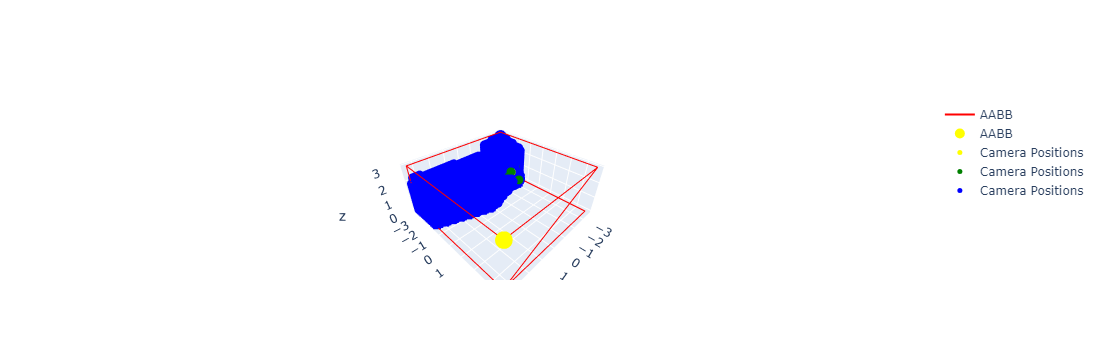

In [51]:
f = draw_aabb(aabb[:3],aabb[3:])
f = draw_cam(f,[target_c2w[:3,3]],color='yellow')
f = draw_cam(f,[cam[:3,3] for cam in dataset.c2ws[cams]],color='green')
f = draw_cam(f,pts)
f.show()

In [13]:
target_num

136

In [32]:
%timeit select_cameras(aabb,target_c2w,target_w2c,target_k,cam_ids,c2ws, w2cs,Ks,N1,N2)

377 ms ± 140 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%timeit select_cameras_origin(aabb,target_c2w,target_w2c,target_k,cam_ids,c2ws,w2cs,Ks,N1,N2)

322 ms ± 82.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
torch.__version__

'2.1.0+cu118'